In [1]:
# Import Pytorch
import torch
import torch.nn as nn

# Import torchvision
import torchvision
from torchvision import  datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu118
0.17.1+cu118


# Getting dataset

In [2]:
# Setup training data
train_data = datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=ToTensor(),
                                  target_transform=None)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

# Analyzing the data

In [4]:
class_names = train_data.classes
class2idx = train_data.class_to_idx
class_names, class2idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

9


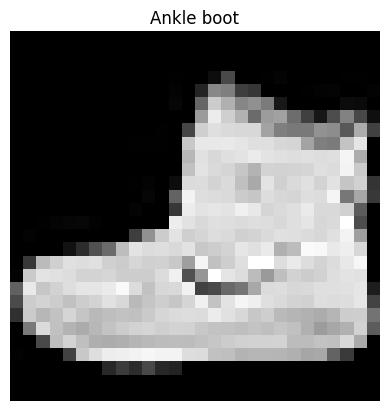

In [5]:
image, label = train_data[0]
print(label)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [6]:
# checking image shape
## [color_channels, height, width]
image.shape

torch.Size([1, 28, 28])

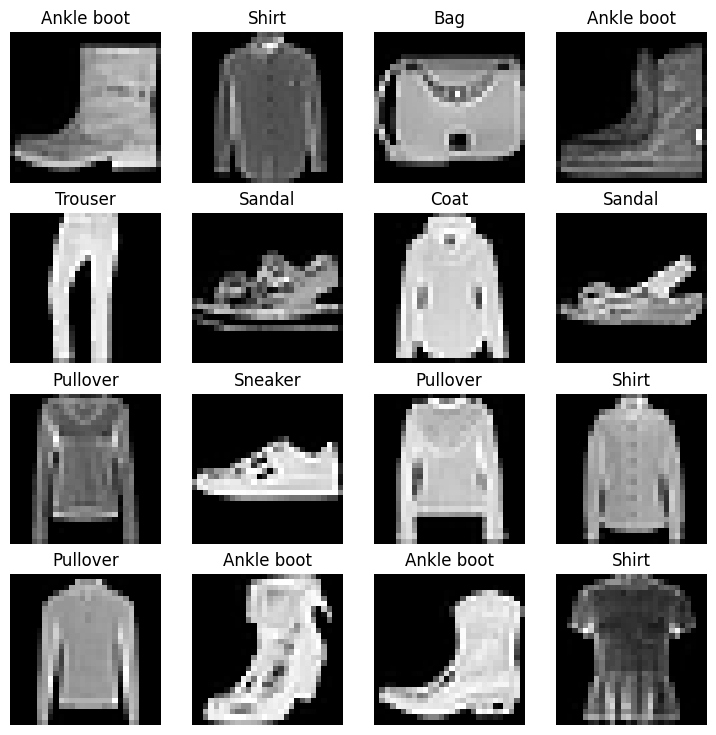

In [7]:
# plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

# Creating Dataloaders

In [8]:
from torch.utils.data import DataLoader

# Setup hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                             shuffle=False)

In [9]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [10]:
next(iter(train_dataloader))[1]

tensor([5, 1, 8, 1, 5, 2, 6, 7, 3, 5, 9, 5, 7, 5, 0, 4, 4, 4, 4, 6, 1, 8, 0, 1,
        9, 7, 8, 8, 3, 3, 7, 2])

In [11]:
train_features_batch = next(iter(train_dataloader))[0]
train_label_batch = next(iter(train_dataloader))

# Model 0: Building a baseline model

In [12]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)
print(x.shape)
print(output.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [13]:
import torch.nn as nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(hidden_units, output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

In [16]:
dummy = torch.rand([1, 1, 28, 28]).to(device)
model_0(dummy)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]],
                     device='cuda:0')),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163], device='cuda:0')),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0

In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    
    """Prints difference between start and end time"""

    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Training loop

In [21]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cuda:0: 10.542 seconds


## Set device agnostic code

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

# Make predictions to get Model 0 results

In [23]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# calculate model 0 results on test dataset
model_0_results = eval_model(
    model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

# Model 1: Building a better model with non-linearity

In [24]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
        )
        
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

## Functionizing Training and Testing loop

In [26]:
import torch.utils
import torch.utils.data


def train_step(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               epochs,
               accuracy_fn,
               device: torch.device = device):
    # Import tqdm for progress bar
    train_loss, train_acc = 0, 0

    # Set the seed and start the timer
    torch.manual_seed(42)
    train_time_start_on_cpu = timer()
    
    losses = []
    accuracy = []


    # Create training and testing loop
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n-------")
        ### Training
        train_loss = 0
        # Add a loop to loop through training batches
        for batch, (X, y) in enumerate(train_dataloader):
            model.train() 
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss (per batch)
            loss = loss_fn(y_pred, y)
            train_loss += loss # accumulatively add up the loss per epoch 
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Print out how many samples have been seen
            # if batch % 400 == 0:
            #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        # Divide total train loss and acc by length of train dataloader (average loss per batch per epoch)
        train_loss /= len(train_dataloader)
        losses.append(train_loss.item())
        
        train_acc /= len(data_loader)
        accuracy.append(train_acc)
        
        print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}")
    
    print(eval_model(model, data_loader, loss_fn,
                     accuracy_fn))
    
    # Calculate training time      
    train_time_end_on_cpu = timer()
    print_train_time(start=train_time_start_on_cpu, 
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))
    
    return losses, accuracy

In [27]:
losses, acc = train_step(model=model_1,
           data_loader=train_dataloader,
           loss_fn=loss_fn,
           optimizer=optimizer,
           epochs=3,
           accuracy_fn=accuracy_fn,
           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.09199 | Train acc: 61.34333
Epoch: 1
-------
Train loss: 0.76867 | Train acc: 72.48105
Epoch: 2
-------
Train loss: 0.66650 | Train acc: 76.13032


  0%|          | 0/1875 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.6467328667640686, 'model_acc': 76.51}
Train time on cuda:0: 14.089 seconds


Text(0, 0.5, 'Accuracy')

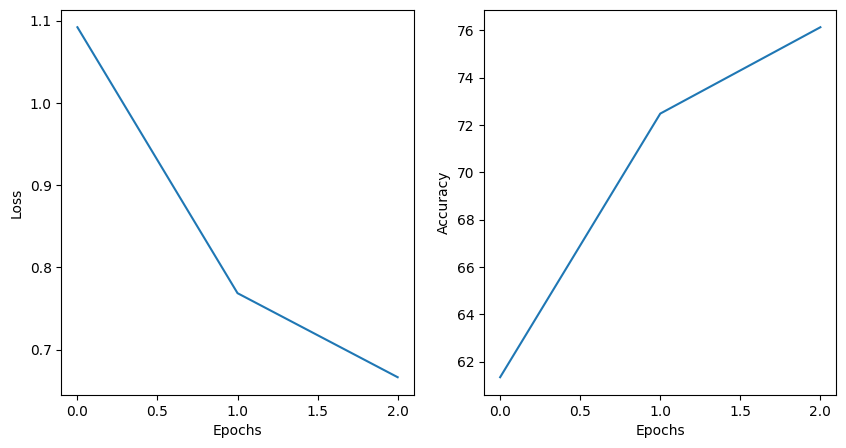

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(acc)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

In [29]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(data_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(data_loader)

        ## Print out what's happening
        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

In [30]:
test_step(model_1, test_dataloader, loss_fn,
          accuracy_fn, device=device)


Train loss: 0.45503 | Test loss: 0.68890, Test acc: 74.98%



# Model 2: Building a Convolutional Neural Network (CNN)

In [36]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(3, 3), stride=1, padding=1),
            
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # print(x.shape)
        out = self.classifier(x)
        return out

In [37]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [38]:
model_2(image.unsqueeze(0).to(device))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Training our Model 2

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [40]:
losses, acc = train_step(model_2, train_dataloader,
           loss_fn, optimizer, 3,
           accuracy_fn, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.60407 | Train acc: 78.08000
Epoch: 1
-------
Train loss: 0.35809 | Train acc: 87.15331
Epoch: 2
-------
Train loss: 0.31781 | Train acc: 88.55982


  0%|          | 0/1875 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3304655849933624, 'model_acc': 88.28666666666666}
Train time on cuda:0: 16.476 seconds


Text(0, 0.5, 'Accuracy')

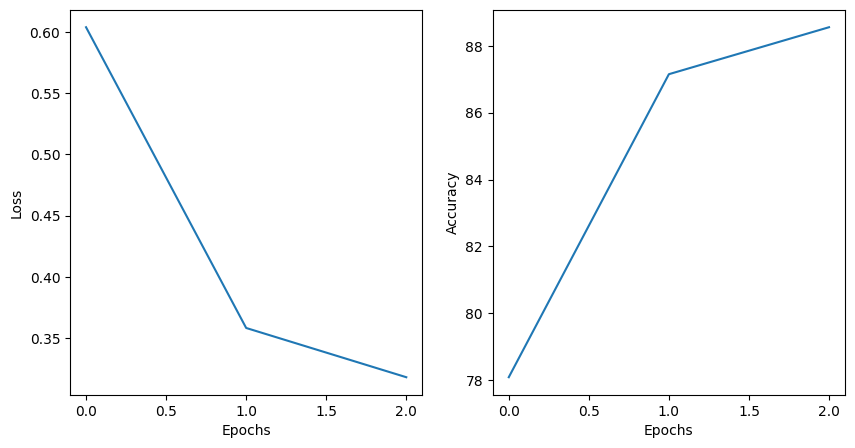

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(acc)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

In [42]:
model_0_results = eval_model(model_0, test_dataloader,
                             loss_fn, accuracy_fn)

model_1_results = eval_model(model_1, test_dataloader,
                             loss_fn, accuracy_fn)

model_2_results = eval_model(model_2, test_dataloader,
                             loss_fn, accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [43]:
import pandas as pd

results  = pd.DataFrame([model_0_results, model_1_results, model_2_results])
results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.688900,74.980032
2,FashionMNISTModelV2,0.364424,87.210463


# Predictions

In [73]:
def make_predictions(model: torch.nn.Module,
                     data, device=device):
    pred_probs = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            # prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass (model outputs raw logits)
            pred_logits = model(sample)

            # get probability
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            
            # get pred_prob off the GPU
            pred_probs.append(pred_prob.cpu())
        
    
    return torch.stack(pred_probs)

In [97]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), 9):
    test_samples.append(sample)
    test_labels.append(label)
    
pred_probs = make_predictions(model_2, test_samples)
pred_labels = pred_probs.argmax(dim=1)

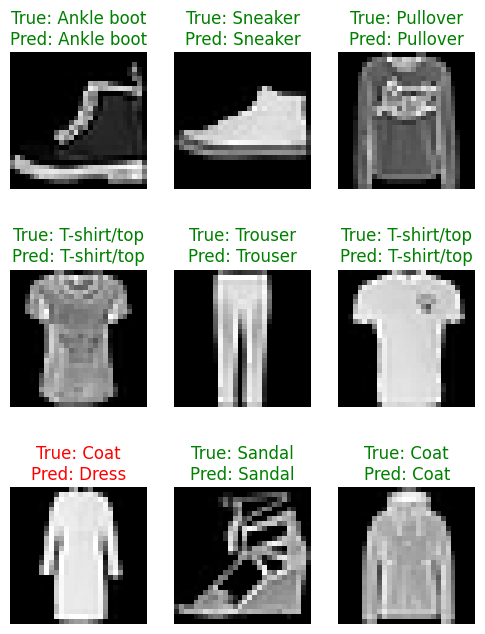

In [98]:
fig, ax = plt.subplots(3, 3, figsize=(6, 8))

for row in range(3):    
    for col in range(3):
        ax[row][col].imshow(test_samples[3*row + col].squeeze(), cmap='gray')
        true_label = class_names[test_labels[3*row + col]]
        pred_label = class_names[pred_labels[3*row + col]]
        
        if true_label==pred_label:
            ax[row][col].set_title(f"True: {true_label}\nPred: {pred_label}", c='g')
        else:
            ax[row][col].set_title(f"True: {true_label}\nPred: {pred_label}", c='r')
        
        ax[row][col].axis(False)
        

## Confusion Matrix

In [104]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [128]:
from tqdm.auto import tqdm

def make_predictions_plot_confusion_matrix(model: torch.nn.Module,
                                           data_loader: torch.utils.data.DataLoader, 
                                           device: torch.device = device):
    y_preds = []
    y_trues = []
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Making predictions"):
            X = X.to(device)

            y_logit = model(X)

            y_pred = torch.argmax(y_logit, dim=1)

            y_preds.append(y_pred.cpu())
            y_trues.append(y)
    
    y_pred_tensor = torch.cat(y_preds)
    y_true_tensor = torch.cat(y_trues)
    
    confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names),
                              )
    confmat_tensor =  confmat(preds=y_pred_tensor, target=y_true_tensor)
    
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        show_absolute=False,
        show_normed=True,
        class_names=class_names,
        figsize=(6, 6)
    )

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

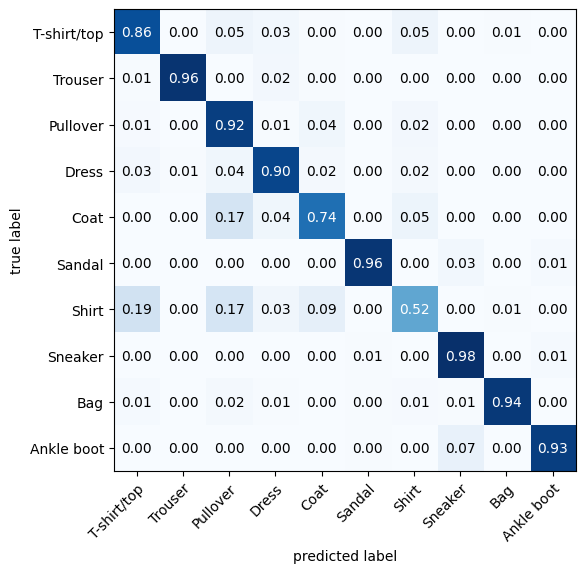

In [129]:
make_predictions_plot_confusion_matrix(model=model_2, data_loader=test_dataloader)